Loaded 570 perf samples.
Aggregated into phases:
        phase       CPI
0      Build  0.916413
1  Execution  2.674842
2   Generate  0.989485

=== Non-negative Linear Regression ===
Intercept (base CPI): 0.540792
L1-dcache-load-misses: 132.970190299
l2_rqsts.demand_data_rd_miss: 0.000000000
LLC-load-misses: 0.000000000
dTLB-load-misses: 0.000000000
branch-load-misses: 19.293443061
RMSE: 0.000000
R^2: 1.000000, Adjusted R^2: nan
F-statistic: 16057820186620885359505327521792.000000, p-value: 0.000000e+00
Saved 'cpi_phases_with_contribs.csv'.


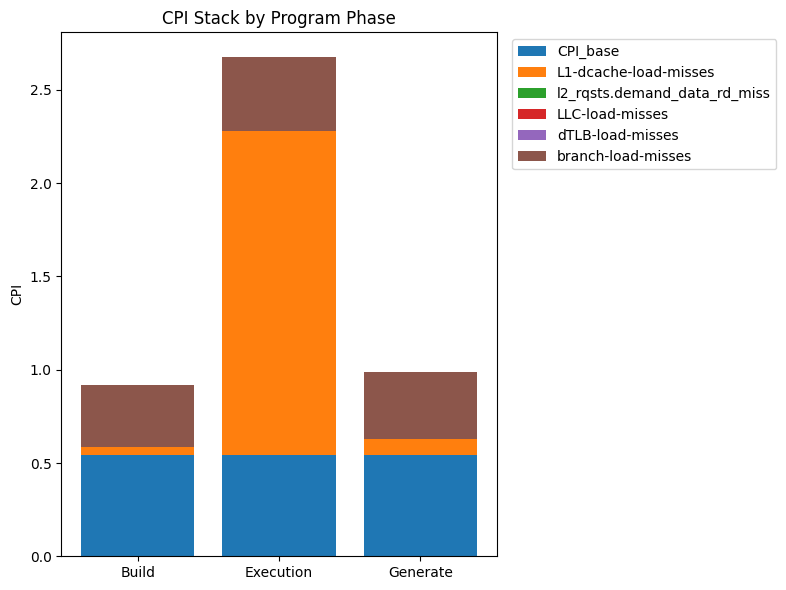


Saved CPI stack plot to 'cpi_stack_by_phase.png'


In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
import matplotlib.pyplot as plt


INPUT_CSV = "perf_counters_intervals.csv"   # parsed perf CSV
FEATURE_COLUMNS = [
    "L1-dcache-load-misses",
    "l2_rqsts.demand_data_rd_miss",
    "LLC-load-misses",
    "dTLB-load-misses",
    "branch-load-misses"
]
TIME_COL   = "time"
CYCLES_COL = "cpu-cycles"
INSTR_COL  = "instructions"


# ---------- Load and clean CSV ----------
def load_and_clean(path):
    df = pd.read_csv(path, dtype=str).rename(columns=lambda c: c.strip())
    def to_int_or_na(x):
        if pd.isna(x): return np.nan
        s = str(x).strip().split()[0].replace(",","")
        if s == "" or s.lower().startswith("<not"): return np.nan
        try: return int(s)
        except: return float(s)
    df[TIME_COL]   = df[TIME_COL].astype(float)
    df[CYCLES_COL] = df[CYCLES_COL].apply(to_int_or_na)
    df[INSTR_COL]  = df[INSTR_COL].apply(to_int_or_na)
    for c in FEATURE_COLUMNS:
        df[c] = df[c].apply(to_int_or_na)
    numeric_cols = [CYCLES_COL, INSTR_COL] + FEATURE_COLUMNS
    df[numeric_cols] = df[numeric_cols].fillna(0).astype(np.int64)
    return df

# ---------- Aggregate into 3 phases ----------
def aggregate_phases(df):
    """
    Phase 0 : Generate  (first row)
    Phase 1 : Build     (second row)
    Phase 2 : Execution (all remaining rows)
    Adjust this logic if your program uses a different split.
    """
    n = len(df)
    if n < 3:
        raise ValueError("Need at least 3 rows (generate, build, execution).")
    phase_labels = (["Generate"] + ["Build"] +
                    ["Execution"] * (n - 2))
    df["phase"] = phase_labels
    agg_cols = [CYCLES_COL, INSTR_COL] + FEATURE_COLUMNS
    grouped = df.groupby("phase")[agg_cols].sum().reset_index()
    grouped["CPI"] = grouped[CYCLES_COL] / grouped[INSTR_COL]
    for c in FEATURE_COLUMNS:
        grouped[c + "_rate"] = grouped[c] / grouped[INSTR_COL]
    return grouped

# ---------- Fit non-negative linear regression ----------
def fit_model(grouped):
    X = grouped[[c + "_rate" for c in FEATURE_COLUMNS]].values
    y = grouped["CPI"].values
    model = LinearRegression(positive=True, fit_intercept=True)
    model.fit(X, y)
    y_pred = model.predict(X)

    # stats
    n, p = X.shape
    residuals = y - y_pred
    SSE = np.sum(residuals**2)
    SSR = np.sum((y_pred - y.mean())**2)
    df_resid = max(1, n - p - 1)
    MSR = SSR / p if p > 0 else np.nan
    MSE = SSE / df_resid if df_resid > 0 else np.nan
    F_stat = MSR / MSE if (MSE and MSE>0) else np.nan
    p_value = 1 - stats.f.cdf(F_stat, p, df_resid) if not np.isnan(F_stat) else np.nan
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1) if (n - p - 1) > 0 else np.nan

    print("\n=== Non-negative Linear Regression ===")
    print(f"Intercept (base CPI): {model.intercept_:.6f}")
    for name, coef in zip(FEATURE_COLUMNS, model.coef_):
        print(f"{name}: {coef:.9f}")
    print(f"RMSE: {rmse:.6f}")
    print(f"R^2: {r2:.6f}, Adjusted R^2: {adj_r2:.6f}")
    print(f"F-statistic: {F_stat:.6f}, p-value: {p_value:.6e}")
    return model, y_pred, residuals

# ---------- Plot 3-phase CPI stack ----------
def plot_stack(grouped, model):
    stacks = []
    for _, row in grouped.iterrows():
        comp = [model.intercept_]
        for i, feat in enumerate(FEATURE_COLUMNS):
            comp.append(model.coef_[i] * row[feat + "_rate"])
        stacks.append(comp)

    labels = ["CPI_base"] + FEATURE_COLUMNS
    stacks = np.array(stacks)

    fig, ax = plt.subplots(figsize=(8,6))
    bottom = np.zeros(3)
    x = np.arange(3)
    for i, lab in enumerate(labels):
        ax.bar(x, stacks[:, i], bottom=bottom, label=lab)
        bottom += stacks[:, i]

    ax.set_xticks(x)
    ax.set_xticklabels(grouped["phase"])
    ax.set_ylabel("CPI")
    ax.set_title("CPI Stack by Program Phase")
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig("cpi_stack_by_phase.png", dpi=150)
    plt.show()
    print("\nSaved CPI stack plot to 'cpi_stack_by_phase.png'")

# ---------- Main ----------
def main():
    df_raw = load_and_clean(INPUT_CSV)
    print(f"Loaded {len(df_raw)} perf samples.")
    grouped = aggregate_phases(df_raw)
    print("Aggregated into phases:\n", grouped[["phase","CPI"]])

    model, y_pred, residuals = fit_model(grouped)
    grouped["CPI_pred"] = y_pred
    grouped["residual"] = residuals
    grouped.to_csv("cpi_phases_with_contribs.csv", index=False)
    print("Saved 'cpi_phases_with_contribs.csv'.")

    plot_stack(grouped, model)

if __name__ == "__main__":
    main()
